### Import Libraries

In [1]:
# Import fungsi time untuk mendapatkan nilai waktu mulai eksekusi
import time
start_time = time.time()
# Import fungsi matematika
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Import fungsi Operating System Directory
import os
from __future__ import print_function, division
from builtins import range, input
# Install and/or Import TF dan Keras & show version
# !pip install tensorflow
# !pip install keras
import tensorflow as tf
from tensorflow import keras
print('Tensorflow version : ', tf.__version__)
print('Keras version : ', keras.__version__)
# Import Pre-trained Model VGG16
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
# Import fungsi untuk Confusion Matrix dan Plot Grafik
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from glob import glob

Tensorflow version :  2.9.1
Keras version :  2.9.0


### Explore Data

Number of CNV files:  27903
Number of DME files:  8511
Number of DRUSEN files:  6462
Number of NORMAL files:  38355
Number of training files: 81231
Number of CNV files:  250
Number of DME files:  250
Number of DRUSEN files:  250
Number of NORMAL files:  250
Number of Images for validating:  1000


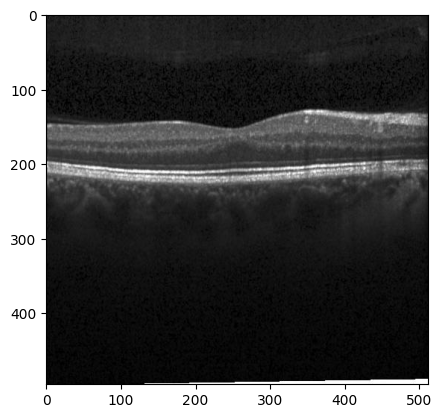

In [2]:
# Explore Dataset
from importlib.resources import path
from random import shuffle

# Set to Current Working Directory
cwd = os.getcwd()
# Choose data partition folder
# OCT = 100 % training data
# OCTThree-Quarter = 75 % training data
# OCTHalf = 50 % training data
# OCTQuarter = 25 % training data
PATH = os.path.join(cwd, 'OCTThree-Quarter')

# function to print number of files in every class
def print_class_count(folder):
    print("Number of CNV files: ", len(glob(folder + '/CNV/*.jp*g')))
    print("Number of DME files: ", len(glob(folder + '/DME/*.jp*g')))
    print("Number of DRUSEN files: ", len(glob(folder + '/DRUSEN/*.jp*g')))
    print("Number of NORMAL files: ", len(glob(folder + '/NORMAL/*.jp*g')))

# Set to train dir and show number of files
train_path = os.path.join(PATH, 'train')
print_class_count(train_path)
train_image_files = glob(train_path + '/*/*.jp*g')
print('Number of training files:', len(train_image_files))

# Set to test dir and show number of files
valid_path = os.path.join(PATH, 'test')
print_class_count(valid_path)
valid_image_files = glob(valid_path + '/*/*.jp*g')
print("Number of Images for validating: ",len(valid_image_files))

# look at an image for fun
plt.imshow(keras.utils.load_img(np.random.choice(train_image_files)))

plt.show()

### Data Preprocessing

In [3]:
batch_size = 32
# re-size all the images to 100x100
IMAGE_SIZE = [100, 100]

# create generators
# create an instance of ImageDataGenerator
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

# useful for getting number of classes
folders = glob(train_path + '/*')
print("Number of classes: ",len(folders))

Found 81231 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.
Number of classes:  4


In [4]:
# add preprocessing layer to the front of VGG
base_model = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
base_model.trainable = False

# view the structure of the model
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [5]:
# our layers
x = Flatten()(base_model.output)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=base_model.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

### Loss and Optimization functions

In [6]:
# tell the model what cost and optimization method to use
base_learning_rate = 0.0001
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
  loss=tf.keras.losses.categorical_crossentropy,
  metrics=['accuracy']
)

In [7]:
# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
    labels[v] = k

Found 1000 images belonging to 4 classes.
{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}


In [8]:
train_st_tm = time.time()

# training config:
initial_epochs = 25

# fit the model
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=initial_epochs,
  steps_per_epoch=len(train_image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)

train_end_tm = time.time()
print("time elapsed for training epochs: ", train_end_tm - train_st_tm)

C:\Users\PC\AppData\Local\Temp\ipykernel_9808\2230626724.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/25
2538/2538 [==============================] - 1394s 549ms/step - loss: 2.3700 - accuracy: 0.6723 - val_loss: 2.8645 - val_accuracy: 0.6038
Epoch 2/25
2538/2538 [==============================] - 1373s 541ms/step - loss: 1.2999 - accuracy: 0.7416 - val_loss: 1.9302 - val_accuracy: 0.6552
Epoch 3/25
2538/2538 [==============================] - 1387s 547ms/step - loss: 1.0597 - accuracy: 0.7563 - val_loss: 1.7146 - val_accuracy: 0.6431
Epoch 4/25
2538/2538 [==============================] - 1393s 549ms/step - loss: 0.9115 - accuracy: 0.7703 - val_loss: 1.2628 - val_accuracy: 0.6875
Epoch 5/25
2538/2538 [==============================] - 1394s 549ms/step - loss: 0.8143 - accuracy: 0.7778 - val_loss: 1.4958 - val_accuracy: 0.6573
Epoch 6/25
2538/2538 [==============================] - 1399s 551ms/step - loss: 0.7657 - accuracy: 0.7811 - val_loss: 1.4068 - val_accuracy: 0.6532
Epoch 7/25
2538/2538 [==============================] - 1398s 551ms/step - loss: 0.7233 - accuracy: 0.7861

In [9]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
    print("Generating confusion matrix", N)
    predictions = []
    targets = []
    i = 0
    for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
        i += 1
        if i % 50 == 0:
            print(i)
        p = model.predict(x)
        p = np.argmax(p, axis=1)
        y = np.argmax(y, axis=1)
        predictions = np.concatenate((predictions, p))
        targets = np.concatenate((targets, y))
        if len(targets) >= N:
            break
    cm = confusion_matrix(targets, predictions)
    return cm


cm = get_confusion_matrix(train_path, len(train_image_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)




Generating confusion matrix 81231
Found 81231 images belonging to 4 classes.
2/2 [==============================] - 1s 547ms/step
50
2/2 [==============================] - 1s 520ms/step
100
2/2 [==============================] - 1s 521ms/step
150
2/2 [==============================] - 1s 509ms/step
200
2/2 [==============================] - 1s 522ms/step
250
2/2 [==============================] - 1s 522ms/step
300
2/2 [==============================] - 1s 510ms/step
350
2/2 [==============================] - 1s 515ms/step
400
2/2 [==============================] - 1s 502ms/step
450
2/2 [==============================] - 1s 558ms/step
500
2/2 [==============================] - 1s 521ms/step
550
2/2 [==============================] - 1s 510ms/step
600
2/2 [==============================] - 1s 519ms/step
650
2/2 [==============================] - 1s 540ms/step
700
2/2 [==============================] - 1s 568ms/step
750
2/2 [==============================] - 1s 502ms/step
800
2/2 [=======

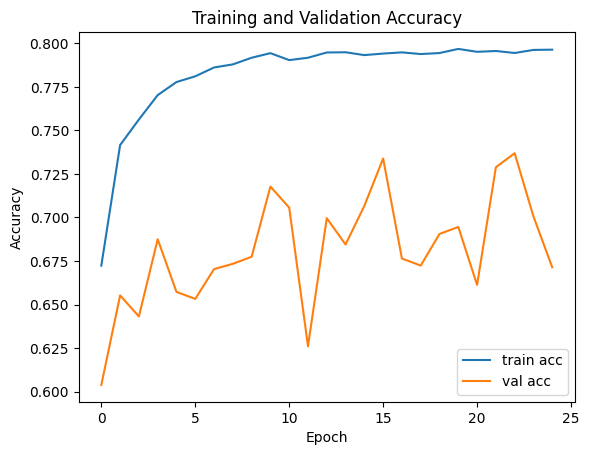

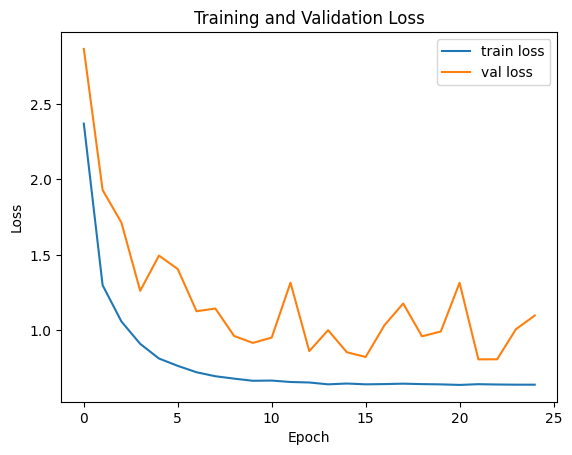

In [10]:
# plot Loss and Accuracies
acc = r.history['accuracy']
val_acc = r.history['val_accuracy']

loss = r.history['loss']
val_loss = r.history['val_loss']

# accuracies
plt.plot(acc, label='train acc')
plt.plot(val_acc, label='val acc')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Training and Validation Accuracy')
plt.show()

# loss
plt.plot(loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.show()




Confusion matrix, without normalization
[[24419  1044   825  1615]
 [ 1074  4125   173  3139]
 [ 2127   309  1340  2686]
 [ 1044  1304   511 35496]]


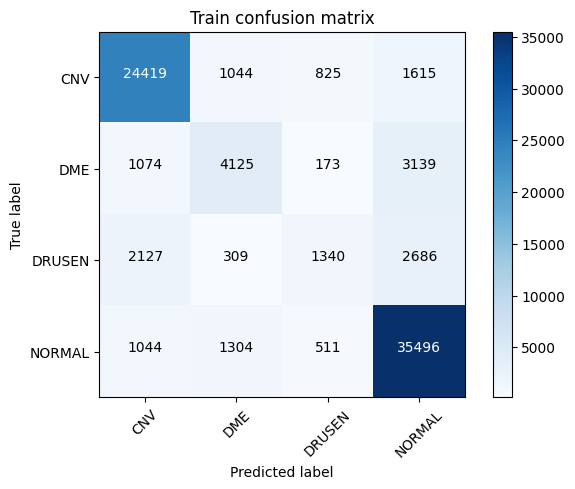

Confusion matrix, without normalization
[[221  15   6   8]
 [ 12 186   1  51]
 [ 64  24  31 131]
 [  5   6   0 239]]


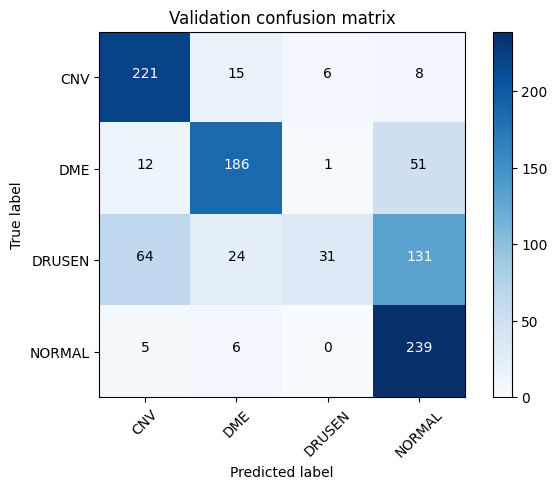

In [11]:
# Plot Confusion Matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
plot_confusion_matrix(cm, labels, title='Train confusion matrix')
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')

### Fine Tuning

In [12]:
# don't train existing weights
for layer in base_model.layers:
    layer.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  19


In [13]:
# Fine tune from this layer onwards
fine_tune_at = 13

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['accuracy']
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [15]:
fine_st_tm = time.time()

fine_tune_epochs = 25
total_epochs =  initial_epochs + fine_tune_epochs

r_fine = model.fit_generator(
    train_generator,
    validation_data=valid_generator,
    epochs=total_epochs,
    initial_epoch=r.epoch[-1],
    steps_per_epoch=len(train_image_files) // batch_size,
    validation_steps=len(valid_image_files) // batch_size,
)

fine_end_tm = time.time()
print("time elapsed for fine-tuning epochs: ", fine_end_tm - fine_st_tm)


Epoch 25/50


C:\Users\PC\AppData\Local\Temp\ipykernel_9808\698310060.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r_fine = model.fit_generator(


2538/2538 [==============================] - 2341s 922ms/step - loss: 0.4158 - accuracy: 0.8599 - val_loss: 0.5528 - val_accuracy: 0.7863
Epoch 26/50
2538/2538 [==============================] - 2344s 923ms/step - loss: 0.3067 - accuracy: 0.8968 - val_loss: 0.4595 - val_accuracy: 0.8317
Epoch 27/50
2538/2538 [==============================] - 2327s 917ms/step - loss: 0.2701 - accuracy: 0.9083 - val_loss: 0.3750 - val_accuracy: 0.8558
Epoch 28/50
2538/2538 [==============================] - 2356s 928ms/step - loss: 0.2483 - accuracy: 0.9162 - val_loss: 0.3848 - val_accuracy: 0.8518
Epoch 29/50
2538/2538 [==============================] - 2337s 921ms/step - loss: 0.2350 - accuracy: 0.9208 - val_loss: 0.4933 - val_accuracy: 0.8185
Epoch 30/50
2538/2538 [==============================] - 2344s 924ms/step - loss: 0.2205 - accuracy: 0.9262 - val_loss: 0.4502 - val_accuracy: 0.8206
Epoch 31/50
2538/2538 [==============================] - 2328s 917ms/step - loss: 0.2127 - accuracy: 0.9289 - va

In [16]:
cm_fine = get_confusion_matrix(train_path, len(train_image_files))
print(cm_fine)
valid_cm_fine = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm_fine)

Generating confusion matrix 81231
Found 81231 images belonging to 4 classes.
2/2 [==============================] - 1s 545ms/step
50
2/2 [==============================] - 1s 551ms/step
100
2/2 [==============================] - 1s 531ms/step
150
2/2 [==============================] - 1s 545ms/step
200
2/2 [==============================] - 1s 547ms/step
250
2/2 [==============================] - 1s 534ms/step
300
2/2 [==============================] - 1s 582ms/step
350
2/2 [==============================] - 1s 570ms/step
400
2/2 [==============================] - 1s 542ms/step
450
2/2 [==============================] - 1s 568ms/step
500
2/2 [==============================] - 1s 551ms/step
550
2/2 [==============================] - 1s 549ms/step
600
2/2 [==============================] - 1s 504ms/step
650
2/2 [==============================] - 1s 513ms/step
700
2/2 [==============================] - 1s 526ms/step
750
2/2 [==============================] - 1s 523ms/step
800
2/2 [=======

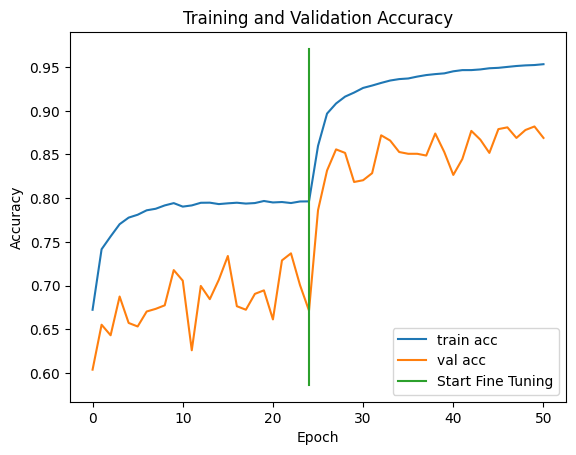

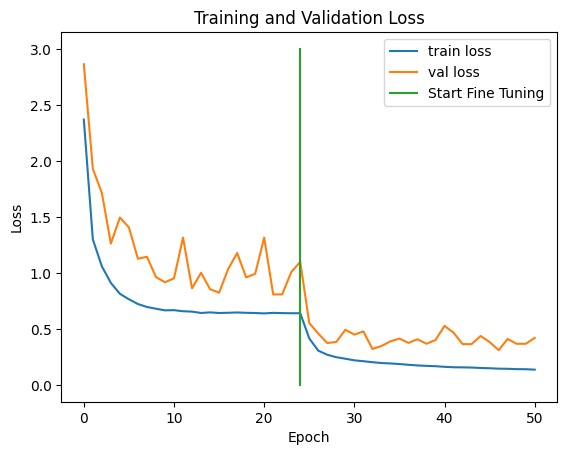

In [17]:
# plot Loss and Accuracies
acc += r_fine.history['accuracy']
val_acc += r_fine.history['val_accuracy']

loss += r_fine.history['loss']
val_loss += r_fine.history['val_loss']

# accuracies
plt.plot(acc, label='train acc')
plt.plot(val_acc, label='val acc')
plt.plot([initial_epochs-1,initial_epochs-1],
        plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Training and Validation Accuracy')
plt.show()

# loss
plt.plot(loss, label='train loss')
plt.plot(val_loss, label='val loss')
plt.plot([initial_epochs-1,initial_epochs-1],
        plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.show()

Confusion matrix, without normalization
[[27179   138   499    87]
 [  162  7758    25   566]
 [  530    76  4641  1215]
 [   58   167   112 38018]]


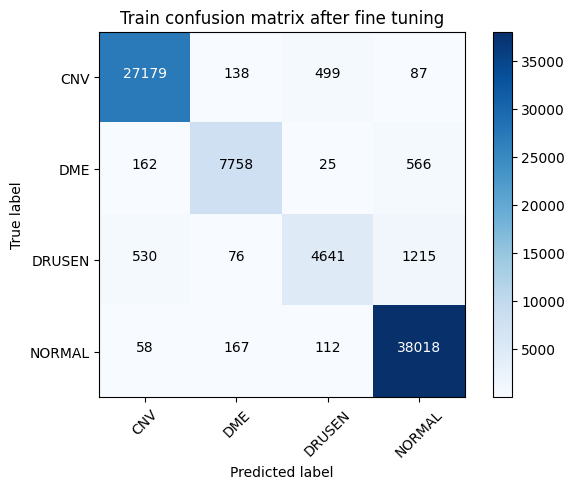

Confusion matrix, without normalization
[[249   1   0   0]
 [  9 240   0   1]
 [ 74   6 120  50]
 [  0   2   1 247]]


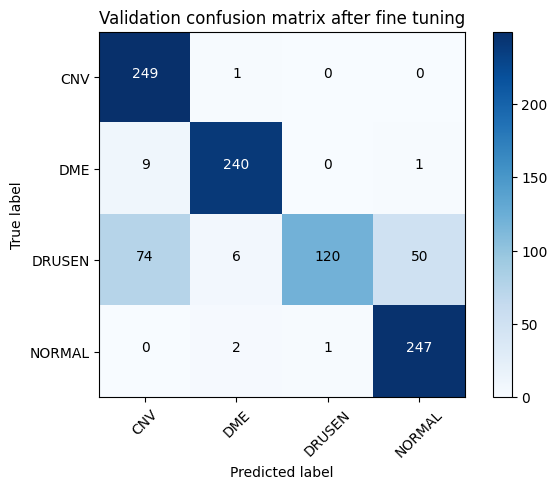

In [18]:
plot_confusion_matrix(cm_fine, labels, title='Train confusion matrix after fine tuning')
plot_confusion_matrix(valid_cm_fine, labels, title='Validation confusion matrix after fine tuning')

In [19]:
end_time = time.time()
print("time elapsed for whole program: ", end_time - start_time)

time elapsed for whole program:  99738.89345049858
